In [ ]:
! pip install networkx

In [ ]:
import requests, matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from random import randint
import requests, json, time, datetime
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configuration
after_date = '12/11/2020'; before_date = '14/11/2020'; subreddit='wallstreetbets'; query = 'GME'; size = 500
drive_path = '/content/drive/MyDrive/'
path = drive_path + f"<={size} reddit submissions from {subreddit} for query {query} after {after_date.replace('/','-')} before {before_date.replace('/','-')}/"
os.makedirs(os.path.dirname(path), exist_ok=True)

In [ ]:
def search_submissions(after, before, subreddit, query, fields, size):
  after  = str((int)(time.mktime(datetime.datetime.strptime(after , "%d/%m/%Y").timetuple()))) 
  before = str((int)(time.mktime(datetime.datetime.strptime(before, "%d/%m/%Y").timetuple())))
  result = requests.get("https://api.pushshift.io/reddit/search/submission/?q="+query+"&subreddit="+subreddit+"&before="+before+"&after="+after+"&size="+str(size)+"&fields="+','.join(fields))
  if not result.status_code==200:
    print('Unable to perform request with status code: ' + str(result.status_code))
    return pd.DataFrame(columns=fields)
  else: 
    return pd.DataFrame(json.loads(result.text)['data'])
  
def clean_data_frame(df):
  return df[(df['author'] != '[deleted]') & (df['author'] != 'AutoModerator')].copy()

In [ ]:
submission_fields = ['author','author_fullname','created_utc','id','removed_by_category','score','selftext','upvote_ratio']
submissions_df = search_submissions(after=after_date, before=before_date, subreddit=subreddit, query=query, fields=submission_fields, size=size)
submissions_df = clean_data_frame(submissions_df)
submissions_df.to_excel(path+'Submissions.xlsx')
submissions_df

,author,author_fullname,created_utc,id,score,selftext,upvote_ratio,removed_by_category
0,Thetrader2896,t2_6fxlcwt4,1605144848,jsle8s,1,Seriously can anyone please explain to my why ...,1.0,NaN
1,robbinhood69,t2_5vuuffi2,1605145143,jslhav,1,I love Cohen and Burry as much as any of u idi...,1.0,NaN
2,aaplfarm,t2_7qovaiu8,1605161064,jspgz4,1,[removed],1.0,moderator
3,iurnaux,t2_qgobgsz,1605193848,jsw8f4,1,,1.0,NaN
4,djstacks313,t2_80on04jo,1605208684,jt1302,1,,1.0,NaN
5,audioeng,t2_9tvn7,1605212492,jt2d7a,1,Lot of people talked about these for awhile an...,1.0,NaN
6,Random-Number1,t2_5nyr7pho,1605212944,jt2ihx,1,&amp;#x200B;\n\n*Processing video lznwr1llcvy5...,1.0,NaN
7,Random-Number1,t2_5nyr7pho,1605213240,jt2m13,1,&amp;#x200B;\n\n*Processing video n9jlsxchdvy5...,1.0,NaN
8,DeepFuckingValue,t2_49l8qytq,1605215499,jt3c45,1,,1.0,NaN
9,ninkorn,t2_3oskv4er,1605246827,jtbqwt,1,Listen up you degenerates.\n\nIf you’ve been p...,1.0,NaN


In [ ]:
def fetch_comments(submission_id, fields):
  result = requests.get("https://api.pushshift.io/reddit/submission/comment_ids/"+submission_id)
  if not result.status_code==200:
    print('Unable to perform request with status code: ' + str(result.status_code))
    return pd.DataFrame(columns=fields)
  else:
    comment_ids = json.loads(result.text)['data']
    result = requests.get("https://api.pushshift.io/reddit/comment/search?ids="+','.join(comment_ids)+"&fields="+','.join(fields)+"&size="+str(min(len(comment_ids),500)))
    if not result.status_code==200:
      print('Unable to perform request with status code: ' + str(result.status_code))
      return pd.DataFrame(columns=fields)
    else:
      result = json.loads(result.text)['data']
      if result == []: return pd.DataFrame(columns=fields)
      else: return pd.DataFrame(result)

In [ ]:
comment_fields = ['author','author_fullname','body','created_utc','id','link_id','score','parent_id','subreddit','subreddit_id']
comments_df = fetch_comments(submission_id=submissions_df.iloc[2]['id'], fields=comment_fields)
comments_df

,author,author_fullname,body,created_utc,id,link_id,score,parent_id,subreddit,subreddit_id


In [ ]:
def update_user_graph(submission, comments_df, g):
  '''For each comment an arc is drawn from the author of the submission to the author of the comment. 
  Within the comments, consider commenter A and commenter B such that B comments on A. Then the author an arc is drawn from author of A to author of B.'''
  comments_df['parent_id'] = comments_df['parent_id'].map(lambda x: x[3:])
    
  for c, comment in comments_df.iterrows():
    # Add edge from submission author to each commenter
    g.add_edge(submission['author'], comment['author'])
    
    # Optionally add edges within commenters
    current_parent_id = comment['parent_id']
    while not current_parent_id == submission['id']:
      parent_df = comments_df[comments_df['id'] == current_parent_id]
      if not len(parent_df) == 1: 
        print(f"there are {len(parent_df)} parents with id {current_parent_id} for comment with id {comment.id} on submission with id {submission.id}")
        break
      else:
        parent = parent_df.iloc[0]
        g.add_edge(parent['author'], comment['author'])
        current_parent_id = parent['parent_id']   

In [ ]:
g = nx.MultiDiGraph()
for s in range(len(submissions_df)):
  if s % 10 == 0: print(f"fetching comments for submission {s}")
  comments_df = fetch_comments(submission_id=submissions_df.iloc[s]['id'], fields=comment_fields)
  comments_df = comments_df.applymap(lambda x: x.encode('unicode_escape').decode('utf-8') if isinstance(x, str) else x)
  comments_df.to_excel(path + 'Comments on submission ' + str(submissions_df.iloc[s]['id']) + '.xlsx')
  update_user_graph(submissions_df.iloc[s].copy(), clean_data_frame(comments_df), g)

nx.write_gpickle(g, path+'Network.pickle')

fetching comments for submission 0
there are 0 parents with id gkxd80n for comment with id gkzaxok on submission with id jt3c45
there are 0 parents with id gm5c492 for comment with id gn4dksg on submission with id jt3c45
fetching comments for submission 10


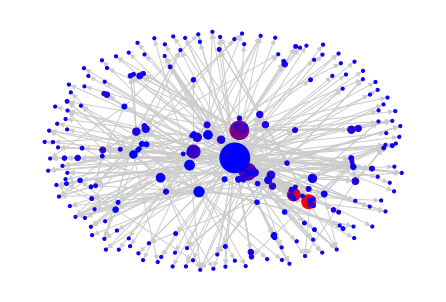

In [ ]:
#g = nx.read_gpickle(path + 'Network.pickle')
d_in = dict(g.in_degree()); max_in = max(d_in.values())
d_out = dict(g.out_degree())
nx.draw(g, edge_color=(0.8,0.8,0.8), nodelist=list(d_in.keys()), node_size=[v*5+10 for v in d_out.values()], node_color=[(v/max_in,0, 1 -v/max_in) for v in d_in.values()])
plt.savefig(path+'Network.png')

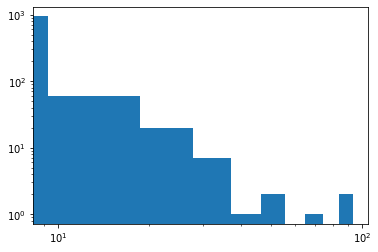

In [ ]:
plt.hist(list(d_in.values()))
plt.yscale('log'); plt.xscale('log')